In [54]:
import streamlit as st
import matplotlib.pyplot as plt
import tempfile
import numpy as np
import pandas as pd
import cv2
import math

class TimeMesurement:
    def __init__(self,filepath):
        #投げられたfile pathから動画と総フレーム、FPSを取得
        self.video = cv2.VideoCapture(filepath)
        self.frame_num = int(self.video.get(cv2.CAP_PROP_FRAME_COUNT))
        self.fps = self.video.get(cv2.CAP_PROP_FPS)
        self.width = int(self.video.get(cv2.CAP_PROP_FRAME_WIDTH))
    
    def lightness(self):
        frames = []
        v_means = []
        self.video.set(cv2.CAP_PROP_POS_FRAMES, 0)
        for i in range(1,self.frame_num):
            ret, frame = self.video.read()
            hsv = cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)
            #動画の中心付近のv値の平均をv_meansに追加
            v_means.append(v[:, int(self.width/2) - 5: int(self.width/2) + 5].mean())
            frames.append(i)
        return np.array(frames), np.array(v_means)
    
    def valid_convolve(self, xx, size):
            #補正された移動平均を出力
            b = np.ones(size)/size
            xx_mean = np.convolve(xx, b, mode="same")

            n_conv = math.ceil(size/2)

            # 補正部分
            xx_mean[0] *= size/n_conv
            for i in range(1, n_conv):
                xx_mean[i] *= size/(i+n_conv)
                xx_mean[-i] *= size/(i + n_conv - (size % 2)) 
            # size%2は奇数偶数での違いに対応するため
            return xx_mean
    
    def sequence_average(self, x):
        #[34,35,56,67,89,90]のような形から、連続している部分の中心を出力(ピークトップとする)
        averages = []
        group = [x[0]]
        for i in range(1,len(x)):
            if x[i] == x[i-1] + 1:
                group.append(x[i])
            
            else:
                averages.append(sum(group) / len(group))
                group = [x[i]]
        averages.append(sum(group) / len(group))
        return averages

    def peakpeak(self,size=10,threshold=4):
        #輝度の時間変化
        x = self.lightness()[1]
        #時間変化の移動平均を産出
        x_mean = self.valid_convolve(x, size) 
        #移動平均との差から鋭いピークを取得
        x_resd = x - x_mean
        #threshold以下の増減はすべて0に
        x_flatten = np.array(list(map(lambda x: 0 if x<threshold else x, x_resd)))
        plt.plot(range(len(x)),x_flatten)
        plt.show()
        x_fla_df = pd.DataFrame(x_flatten,columns=["frame"])
        non_zero_frames =  x_fla_df[x_fla_df["frame"] != 0 ].index
        peak_frames = self.sequence_average(non_zero_frames)
        return np.array(peak_frames)

In [55]:
TM = TimeMesurement("./test_movie/test_start2.mov")
TM.fps

29.974798636161488

In [56]:
TM.peakpeak(1)

TypeError: only integer scalar arrays can be converted to a scalar index

In [27]:
light = TM.lightness()

In [29]:
ave = TM.valid_convolve(light[1],len(light))

In [33]:
ave == light[1]

array([ True, False, False, ..., False, False, False])

In [ ]:
TM

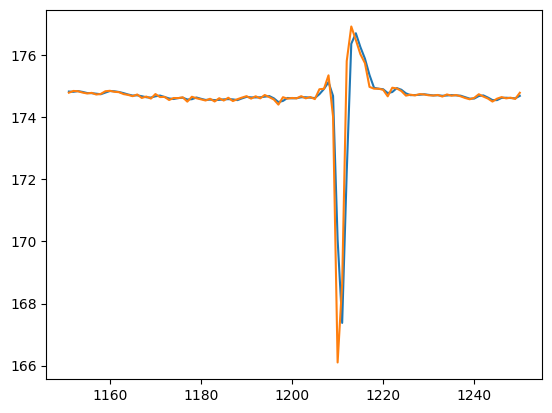

In [36]:
%matplotlib inline
plt.plot(light[0][1150:1250],ave[1150:1250])
plt.plot(light[0][1150:1250],light[1][1150:1250])
plt.show()

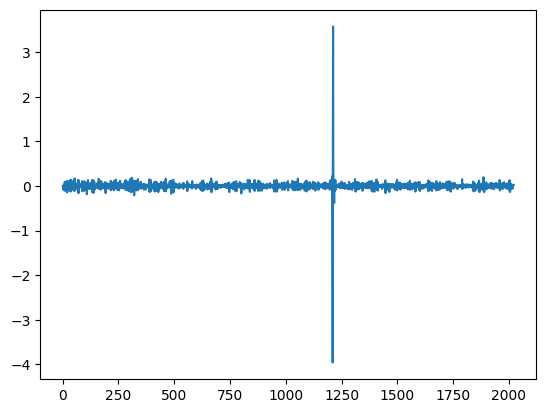

In [37]:
%matplotlib inline
plt.plot(light[0],light[1]-ave)
plt.show()

In [6]:
for f in light:
    TM.video.set(cv2.CAP_PROP_POS_FRAMES, int(f))
    ret,frame = TM.video.read()
    cv2.imwrite(f"{f}frame_start.png", frame)

In [ ]:
pae

In [ ]:
TM.video.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret,frame = TM.video.read()
# フレームサイズを取得して空の配列を作成
average_frame = np.zeros_like(frame, np.float32)  # フロート型にしておく
# フレームのカウント
frame_count = 0
# フレームごとの合計を計算
while ret:
    # フレームをfloat32に変換して足し算
    frame_float = frame.astype(np.float32)
    average_frame += frame_float

    # 次のフレームを読み込み
    ret, frame = TM.video.read()
    frame_count += 1

# 動画を閉じる
TM.video.release()

# フレーム数で割って平均化
average_frame /= frame_count
average_frame = np.clip(average_frame, 0, 255)  # ピクセル値が0-255の範囲内に収まるようにする
average_frame = average_frame.astype(np.uint8)


In [ ]:
average_frame

In [ ]:
cv2.imwrite("average_frame.png", average_frame)

In [ ]:
TM = TimeMesurement("./test_movie/test_1.MOV")
TM.video.set(cv2.CAP_PROP_POS_FRAMES, 5600)
ret,frame = TM.video.read()
f32 = frame.astype(np.float32)
af32 = average_frame.astype(np.float32)
test_frame = np.clip(f32-af32, 0, 255)  # ピクセル値が0-255の範囲内に収まるようにする
test_frame = test_frame.astype(np.uint8)
cv2.imwrite("test.png", test_frame)

In [ ]:
cv2.imwrite("frame.png", frame)

In [ ]:
average_frame

In [ ]:
import cv2
import numpy as np

# 動画ファイルのパス
video_path = "./test_movie/test_start.mov"
output_video_path = 'difference_video_3.mp4'

# 動画を読み込む
cap = cv2.VideoCapture(video_path)

# 最初のフレームを取得してフレームサイズを確認
ret, frame = cap.read()

# 動画が開けない場合の処理
if not ret:
    print("動画が開けませんでした")
    cap.release()
    exit()

# フレームサイズとFPS（フレームレート）を取得
frame_height, frame_width, _ = frame.shape
fps = cap.get(cv2.CAP_PROP_FPS)

# 動画の書き出しの準備 (MP4フォーマットで保存)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # コーデックの指定
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# 平均フレームの計算（前回の手順に従って計算）
average_frame = np.zeros_like(frame, np.float32)
frame_count = 0

# フレームごとの合計を計算
while ret:
    frame_float = frame.astype(np.float32)
    average_frame += frame_float
    ret, frame = cap.read()
    frame_count += 1

# フレーム数で割って平均化
average_frame /= frame_count
average_frame = np.clip(average_frame, 0, 255)
average_frame = average_frame.astype(np.uint8)

# 動画をリセットして再度読み込む
cap.release()
cap = cv2.VideoCapture(video_path)

# 各フレームと平均フレームの差分を計算して保存
ret, frame = cap.read()
while ret:
    # 差分を計算 (絶対差分)
    diff_frame = cv2.absdiff(frame, average_frame)
    
    # RGB変換処理
    diff_frame = cv2.cvtColor(diff_frame, cv2.COLOR_BGR2RGB)

    # 差分フレームを書き込み
    out.write(diff_frame)
    
    # 次のフレームを読み込む
    ret, frame = cap.read()

# リソースの解放
cap.release()
out.release()
cv2.destroyAllWindows()

print("差分動画が保存されました: ", output_video_path)

In [2]:
#人を切り抜き

import cv2
import numpy as np

# 動画ファイルのパス
video_path = "./test_movie/test_2.MOV"
output_video_path = 'difference_video_4.mp4'

# 動画を読み込む
cap = cv2.VideoCapture(video_path)

# 最初のフレームを取得してフレームサイズを確認
ret, frame = cap.read()

# 動画が開けない場合の処理
if not ret:
    print("動画が開けませんでした")
    cap.release()
    exit()


#hsv空間に変換
hsv = cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)

# フレームサイズとFPS（フレームレート）を取得
frame_height, frame_width, _ = frame.shape
fps = cap.get(cv2.CAP_PROP_FPS)

# 動画の書き出しの準備 (MP4フォーマットで保存)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # コーデックの指定
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height),isColor=False)

# 平均フレームの計算（前回の手順に従って計算）
average_frame = np.zeros_like(v, np.float32)
frame_count = 0

# フレームごとの合計を計算
while ret:
    frame_float = v.astype(np.float32)
    average_frame += frame_float
    ret, frame = cap.read()
    if not ret:
        break
    hsv = cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    frame_count += 1
    

# フレーム数で割って平均化
average_frame /= frame_count
average_frame = np.clip(average_frame, 0, 255)
average_frame = average_frame.astype(np.uint8)

# 動画をリセットして再度読み込む
cap.release()
cap = cv2.VideoCapture(video_path)

# 各フレームと平均フレームの差分を計算して保存
ret, frame = cap.read()
while ret:
    #hsv空間に変換
    hsv = cv2.cvtColor(frame,cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    # 差分を計算 (絶対差分)
    diff_frame = cv2.absdiff(v, average_frame)

    # 差分フレームを書き込み
    out.write(diff_frame)
    
    # 次のフレームを読み込む
    ret, frame = cap.read()

# リソースの解放
cap.release()
out.release()
cv2.destroyAllWindows()

print("差分動画が保存されました: ", output_video_path)

差分動画が保存されました:  difference_video_4.mp4
